Authors : <br> 
Remy Cordeau <br>
Jules Lagarde <br>

# Lab 3

In [42]:
import collections
import math

def entropy(l):
    c = collections.Counter(l)
    p = [v/len(l) for v in c.values()]
    return -sum([p[i]*math.log2(p[i]) for i in range(len(p))])

## Question 1

In [43]:
import collections
import numpy as np
import math


def mutual_entropy(x,y):
    assert len(x)==len(y), "X and Y doesn't have the same length :)"
    n = len(x)
    x_vals, y_vals = list(set(x)),list(set(y))
    x_vals_T = dict([(v,i) for i, v in enumerate(x_vals)])
    y_vals_T = dict([(v,i) for i, v in enumerate(y_vals)])
    t = np.zeros((len(x_vals), len(y_vals)))
    cnt = collections.Counter(zip(x, y))
    for (vx, vy), c in cnt.items():
        t[x_vals_T[vx], y_vals_T[vy]]+=c
    
    t/=n
    p_x = np.sum(t, axis=1)
    p_y = np.sum(t, axis=0)
            
    i_x_y = 0
    for vx, vy in cnt.keys():
        i, j = x_vals_T[vx], y_vals_T[vy]
        i_x_y +=  t[i, j]*math.log2( t[i, j]/(p_x[i]*p_y[j]))
    
    return 2*i_x_y/(entropy(x)+entropy(y))

In [44]:
mutual_entropy(
    np.array([3,2,4,4,2,1,2,2,3,3,1,2,5,1,5,4,3,3,2,3]),
    np.array([1,2,2,2,2,5,2,2,1,1,5,2,5,5,5,2,1,1,2,1]))

0.8243697339838489

# Question 2

In [45]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


sbird_2d = np.array(mpimg.imread("bird_small.tiff"))
sbird = np.reshape(sbird_2d, (-1, 3))
kmeans = KMeans(n_clusters=10, random_state=2)
kmeans.fit(sbird)
sbird_sd = np.uint8([kmeans.cluster_centers_[l] for l in kmeans.labels_])

sbird_sd_2d = np.reshape(sbird_sd, sbird_2d.shape)
mpimg.imsave("bird_small_sd.tiff", sbird_sd_2d)

In [46]:
r, g, b = np.array(list(zip(*sbird)))

In [47]:
print("I(r, g)", mutual_entropy(r, g))
print("I(r, b)", mutual_entropy(r, b))
print("I(b, g)", mutual_entropy(b, g))

I(r, g) 0.41710661314784503
I(r, b) 0.34699495559853133
I(b, g) 0.37353781164925576


The pair with the least mutual information is (r,b)

In [48]:
r, g, b = np.array(list(zip(*sbird_sd)))

In [49]:
print("I(r, g)", mutual_entropy(r, g))
print("I(r, b)", mutual_entropy(r, b))
print("I(b, g)", mutual_entropy(b, g))

I(r, g) 1.0
I(r, b) 1.0
I(b, g) 1.0


If we do the same with the image after clustering (10 clusters), we can see that the mutual information is maxed out.

## Question 3

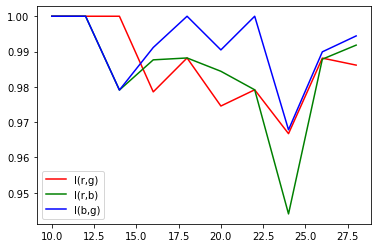

In [61]:
rg = np.arange(10,30,2)
data = []
for k in rg:
    km = KMeans(n_clusters=k, random_state=2)
    km.fit(sbird)
    sb_sd = np.uint8([km.cluster_centers_[l] for l in km.labels_])
    r, g, b = np.array(list(zip(*sb_sd)))
    data.append((mutual_entropy(r, g),mutual_entropy(r, b),mutual_entropy(b, g)))

data = list(zip(*data)) # transpose the matrix (eg. change shape from (n, 3) to (3, n) ) 
plt.plot(rg, data[0], color="red", label="I(r,g)")
plt.plot(rg, data[1], color="green", label="I(r,b)")
plt.plot(rg, data[2], color="blue", label="I(b,g)")
plt.legend()
plt.show()

We can see that the more clusters there are, the less mutual information there is. Moreover we can see that the mutual information variation is independant from pairs of color components

# Lab 4
## Question 1

In [51]:
import scipy.io
import numpy as np
loaded_mat = scipy.io.loadmat('Indian_pines.mat')
mat = loaded_mat["indian_pines"]
mat = mat.reshape(-1, 220)
mat = mat.T
mat_gt = scipy.io.loadmat('Indian_pines_gt.mat')
mat_gt = mat_gt["indian_pines_gt"]
mat_gt = mat_gt.reshape(-1)

In [52]:
loaded_mat['indian_pines'].shape

(145, 145, 220)

In [53]:
def argmax(args, func):
    l = np.array([(a,func(a)) for a in args])
    return l.T[0][np.argmax(l.T[1])]

x_set = set(range(mat.shape[0]))
z= [0]*20
z[0] = int(argmax(x_set, lambda x:mutual_entropy(mat[x], mat_gt)))
x_set.remove(z[0])

$z_k = arg max_{x\in{X}}\backslash\{z_1,..., z_{k-1}\}\bigg[I(y;x)-\frac{1}{k-1}\sum_{i=1}^{k-1}{I(z_i;x)}\bigg]$

In [ ]:
print(z)
for k in range(1,len(z)):
    z[k] = int(argmax(x_set, lambda x:mutual_entropy(mat[x], mat_gt)-(1/(k-1))*sum([mutual_entropy(mat[z[i]], mat[x]) for i in range(0,k)])))
    x_set.remove(z[k])
    print(z)

## Question 2 and 3

In [ ]:
print(z, k)

0.5065398335315101
0.5816884661117717
0.5864447086801428
0.5933412604042807
0.5931034482758621
0.5912009512485136
0.5862068965517242
0.5907253269916767
0.6349583828775268
0.6337693222354341


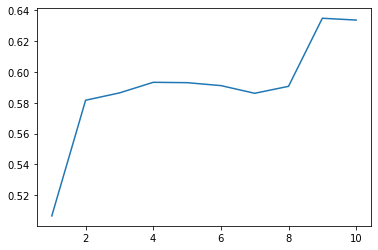

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np


scaler = StandardScaler()
scaler.fit(mat)
mat_norm = scaler.transform(mat)

def plot(z):
    rg = np.arange(1,len(z)+1,1)
    data = []
    for k in rg:
        mat_s = np.array([mat_norm[i] for i in z[:k]])
        mat_s_train, mat_s_test, mat_gt_train, mat_gt_test = train_test_split(mat_s.T, mat_gt, test_size=0.2, random_state=0)
        knn = KNeighborsClassifier()
        knn.fit(mat_s_train, mat_gt_train)

        confusion_mat = np.array(confusion_matrix(knn.predict(mat_s_test), mat_gt_test))/len(mat_gt_test)
        print(np.trace(confusion_mat))
        data.append(np.trace(confusion_mat))

    plt.plot(rg, data)

plot(z[:10])

As expected, the trace of the confustion matrix increase as the number of bands does.

## Question 4

In [ ]:
import random 

z_shuffle = z[:10]
random.shuffle(z_shuffle)
print(z, '\n', z_shuffle)
plot(z_shuffle)

As expected, the trace continues to increase but discontinuously because the bands are present in a random order.